In [1]:
import numpy as np
import pickle as pickle
import pandas as pd
import math
import seaborn as sns

import matplotlib.pyplot as plt

import pyeeg as pe
import pywt

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

In [27]:
import tensorflow as tf
import keras

from tensorflow.keras.utils import to_categorical 

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense

from keras.layers import Bidirectional, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report

# Datasets Preparation

## Data Preprocessing

### Epoching + Label Mapping

In [45]:
# https://arxiv.org/pdf/1911.12918.pdf

def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence > 5 and arousal > 5):
        label = 0 #'HVHA'
    elif (valence > 5 and arousal <= 5):
        label = 1 #'HVLA'
    elif (valence <= 5 and arousal > 5):
        label = 2 #'LVHA'
    elif (valence <= 5 and arousal <= 5):
        label = 3 #'LVLA'
    
    return label

In [46]:
def map_label(label):
    new_label = label_mapping(label[0], label[1]) 
    return new_label

In [148]:
chan = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
print(chan)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


In [149]:
# https://sci-hub.se/https://ieeexplore.ieee.org/document/8856854

#F3,F7,T7,P7,O1,F4,F8,T8,P8,O2
# channel = [2,3,7,11,13,19,20,25,29,31]
#AF3 1, F3 2, F7 3, FC5 4, T7 7, P7 11, O1 13, O2 31, P8 29, T8 25, FC6 21, F4 19, F8 20, AF4 17
channel = [1,2,3,4,7,11,13,17,19,20,21,25,29,31]
channel_test = [0, 16] # Fp1, Fp2

window_size = 256 #Averaging band power of 2 sec
step_size = 256 #Each 1 sec update once
subject_list = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25','26','27','28','29','30'
    ,'31','32'
]

subject_train = [
    '01','02','03','04','05','06','07','08','09','10'
    ,'11','12','13','14','15','16','17','18','19','20'
    ,'21','22','23','24','25'
]

subject_val = ['26','27','28','29','30']
subject_test = ['31','32']

In [150]:
def epoching (sub, channel, window_size, step_size):
    
    signal = []
    with open("C:\.Farhad\.Telkom\Emotion Recognition\Datasets\DEAP\data_preprocessed_python\s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trials
            data = subject["data"][i]
            labels = subject["labels"][i]
            labels = np.array(map_label(labels))
            start = 0;

            while start + window_size <= data.shape[1]:
                array = []
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 1 sec
                    array.append(np.array(X))
                    array.append(np.array(labels))
                    signal.append(np.array(array))
  
                start = start + step_size
                
        signal = np.array(signal)
        np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\s' + sub, signal, allow_pickle=True, fix_imports=True)
#         np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\train\\s' + sub, signal, allow_pickle=True, fix_imports=True)
#         np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\val\\s' + sub, signal, allow_pickle=True, fix_imports=True)
#         np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\test\\s' + sub, signal, allow_pickle=True, fix_imports=True)
            

In [151]:
for subjects in subject_list:
    epoching (subjects, channel, window_size, step_size)
    print(subjects)

C:\Users\zaman\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\zaman\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [43]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\train\\s01' + '.npy', 'rb') as file:
    sub = np.load(file,allow_pickle=True)

In [44]:
print(sub.shape)
print(sub[0].shape)
print(sub[0][0].shape)
print(sub[0][1].shape)

(24800,)
(2,)
(256,)
()


# [Deprecated] Data Preparation

In [55]:
def balancer(X, Y):
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0
    
    unique, counts = np.unique(Y, return_counts=True)
    label_dist = dict(zip(unique, counts))

    len_data = min(label_dist.values())

    x_train = []
    y_train = []

    for i in range(len(Y)):
        if (Y[i] == 0):
            if (count0 < len_data):
                x_train.append(np.array(X[i]))
                y_train.append(np.array(Y[i]))
                count0 = count0 + 1
            else:
                pass
        elif (Y[i] == 1):
            if (count1 < len_data):
                x_train.append(np.array(X[i]))
                y_train.append(np.array(Y[i]))
                count1 = count1 + 1
            else:
                pass
        elif (Y[i] == 2):
            if (count2 < len_data):
                x_train.append(np.array(X[i]))
                y_train.append(np.array(Y[i]))
                count2 = count2 + 1
            else:
                pass
        elif (Y[i] == 3):
            if (count3 < len_data):
                x_train.append(np.array(X[i]))
                y_train.append(np.array(Y[i]))
                count3 = count3 + 1
            else:
                pass

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    return x_train, y_train

## Train Dataset

In [124]:
data = []
label = []

for subjects in subject_train:

    with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\train\\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
                data.append(sub[i][0])
                label.append(sub[i][1])

# x_train, y_train = balancer(data, label)
x_train = data
y_train = to_categorical(label)

np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(x_train).shape, np.array(y_train).shape)
# print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (310000, 256) (310000, 4)


In [125]:
unique, counts = np.unique(label, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

y = []
for i in range(len(y_train)):
    y.append(np.argmax(y_train[i]))

unique, counts = np.unique(y, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 102920, 1: 62620, 2: 78430, 3: 66030}
{0: 102920, 1: 62620, 2: 78430, 3: 66030}


## Validation Dataset

In [126]:
data = []
label = []

for subjects in subject_val:

    with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\val\\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
                data.append(sub[i][0])
                label.append(sub[i][1])

# x_val, y_val = balancer(data, label)
x_val = data
y_val = to_categorical(label)

np.save('C:\\.Farhad\.Telkom\Emotion Recognition\Datasets\\DEAP\\x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
print("Validation datasets:", np.array(x_val).shape, np.array(y_val).shape)

Validation datasets: (62000, 256) (62000, 4)


In [127]:
unique, counts = np.unique(label, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

y = []
for i in range(len(y_val)):
    y.append(np.argmax(y_val[i]))

unique, counts = np.unique(y, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 27900, 1: 12710, 2: 4960, 3: 16430}
{0: 27900, 1: 12710, 2: 4960, 3: 16430}


## Test Dataset

In [128]:
data = []
label = []

for subjects in subject_test:

    with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\test\\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
                data.append(sub[i][0])
                label.append(sub[i][1])

# x_test, y_test = balancer(data, label)
x_test = data
y_test = to_categorical(label)

np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\y_test', np.array(y_test), allow_pickle=True, fix_imports=True)
print("Testing datasets:", np.array(x_test).shape, np.array(y_test).shape)

Testing datasets: (24800, 256) (24800, 4)


In [129]:
unique, counts = np.unique(label, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

y = []
for i in range(len(y_test)):
    y.append(np.argmax(y_test[i]))

unique, counts = np.unique(y, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 5270, 1: 8060, 2: 8990, 3: 2480}
{0: 5270, 1: 8060, 2: 8990, 3: 2480}


In [122]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

In [123]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(310000, 256)
(250480, 4, 2)
(62000, 256)
(19840, 4, 2)
(24800, 256)
(24800, 4)


In [72]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [75]:
y = []

for i in range(len(y_test)):
    y.append(np.argmax(y_test[i]))

unique, counts = np.unique(y, return_counts=True)
label_dist = dict(zip(unique, counts))
label_dist

{0: 10540, 1: 16120, 2: 17980, 3: 4960}

# [Fixed] Data Preparation

## Combine Data

In [153]:
data = []
label = []

for subjects in subject_list:

    with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            data.append(sub[i][0])
            label.append(sub[i][1])

np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\DEAP\\all\\data', np.array(data), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\DEAP\\all\\label', np.array(label), allow_pickle=True, fix_imports=True)
print("Training datasets:", np.array(data).shape, np.array(label).shape)

Training datasets: (555520, 256) (555520,)


In [155]:
unique, counts = np.unique(label, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 190526, 1: 116746, 2: 129332, 3: 118916}


In [162]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\DEAP\\all\\data.npy', 'rb') as fileTrain:
    data  = np.load(fileTrain)
    
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\DEAP\\all\\label.npy', 'rb') as fileTrainL:
    label  = np.load(fileTrainL)

## Train Val Test Split

In [163]:
print(data.shape)
print(label.shape)

(555520, 256)
(555520,)


In [164]:
x_train, x, y_train, y = train_test_split(data, label, test_size=0.4, random_state=42)

In [165]:
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

In [166]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(333312, 256)
(333312,)
(111104, 256)
(111104,)
(111104, 256)
(111104,)


In [167]:
unique, counts = np.unique(y_train, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_val, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)
unique, counts = np.unique(y_test, return_counts=True)
label_dist = dict(zip(unique, counts))
print(label_dist)

{0: 114311, 1: 69746, 2: 77599, 3: 71656}
{0: 38090, 1: 23662, 2: 25815, 3: 23537}
{0: 38125, 1: 23338, 2: 25918, 3: 23723}


In [168]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Save and Load Datasets

In [169]:
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\x_train', np.array(x_train), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\y_train', np.array(y_train), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\x_val', np.array(x_val), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\y_val', np.array(y_val), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\x_test', np.array(x_test), allow_pickle=True, fix_imports=True)
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DREAMER\\y_test', np.array(y_test), allow_pickle=True, fix_imports=True)

In [170]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_train.npy', 'rb') as file:
    x_train = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\y_train.npy', 'rb') as file:
    y_train = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_val.npy', 'rb') as file:
    x_val = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\y_val.npy', 'rb') as file:
    y_val = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_test.npy', 'rb') as file:
    x_test = np.load(file, allow_pickle=True)
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\y_test.npy', 'rb') as file:
    y_test = np.load(file, allow_pickle=True)

# Scaling and Normalization

In [171]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(333312, 256)
(333312, 4)
(111104, 256)
(111104, 4)
(111104, 256)
(111104, 4)


In [172]:
scaler = StandardScaler()

In [173]:
# 4 Normalization -> Standardization 
x_train = scaler.fit_transform(normalize(x_train))
x_val = scaler.fit_transform(normalize(x_val))
x_test = scaler.fit_transform(normalize(x_test))

## Sample

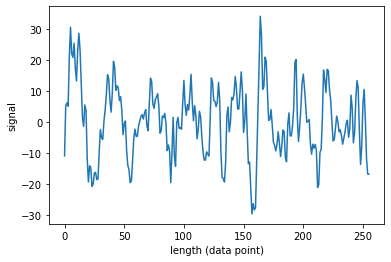

In [189]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

plt.plot(sample[0])
# plt.title("Epoched Data Sample")
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

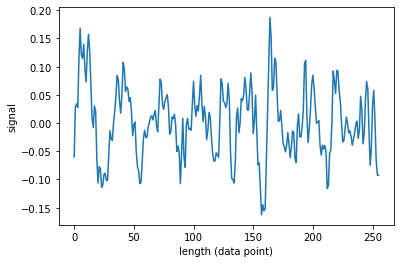

In [190]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

sample = normalize(sample)
    
plt.plot(sample[0])
# plt.title("Data Sample After Z-Score Standardization")
plt.ylabel('signal')
plt.xlabel('length (data point)')
plt.show()

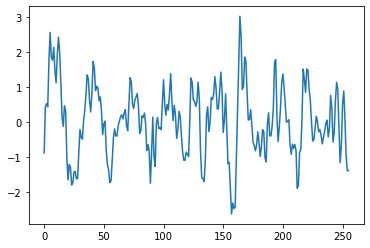

In [191]:
with open('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\x_train.npy', 'rb') as file:
    sample = np.load(file, allow_pickle=True)

sample = scaler.fit_transform(normalize(sample))
    
plt.plot(sample[0])
plt.show()

## Reshaping

In [174]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0],x_test.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [175]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(333312, 256, 1)
(111104, 256, 1)
(111104, 256, 1)
(333312, 4)
(111104, 4)
(111104, 4)


# Train Data

In [176]:
input_shape=(x_train.shape[1],x_train.shape[2])
print(input_shape)

(256, 1)


In [177]:
batch_size = 256
num_classes = 4
epochs = 200

## Model 2: GRU

In [178]:
model_2 = Sequential()

model_2.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(Conv1D(128, 3,  activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 256, return_sequences=True))  
model_2.add(Dropout(0.2))

model_2.add(GRU(units = 32))
model_2.add(Dropout(0.2))

model_2.add(Flatten())

model_2.add(Dense(units = 128, activation='relu'))
model_2.add(Dropout(0.2))

model_2.add(Dense(units = num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
gru (GRU)                    (None, 62, 256)         

In [179]:
model_2.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [180]:
history_2 = model_2.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/200
1302/1302 [==============================] - 58s 39ms/step - loss: 1.3659 - accuracy: 0.3423 - val_loss: 1.3638 - val_accuracy: 0.3428
Epoch 2/200
1302/1302 [==============================] - 50s 38ms/step - loss: 1.3634 - accuracy: 0.3431 - val_loss: 1.3608 - val_accuracy: 0.3453
Epoch 3/200
1302/1302 [==============================] - 50s 38ms/step - loss: 1.3605 - accuracy: 0.3446 - val_loss: 1.3556 - val_accuracy: 0.3490
Epoch 4/200
1302/1302 [==============================] - 50s 38ms/step - loss: 1.3574 - accuracy: 0.3460 - val_loss: 1.3473 - val_accuracy: 0.3545
Epoch 5/200
1302/1302 [==============================] - 50s 39ms/step - loss: 1.3503 - accuracy: 0.3510 - val_loss: 1.3360 - val_accuracy: 0.3608
Epoch 6/200
1302/1302 [==============================] - 50s 39ms/step - loss: 1.3377 - accuracy: 0.3606 - val_loss: 1.2993 - val_accuracy: 0.3882
Epoch 7/200
1302/1302 [==============================] - 50s 39ms/step - loss: 1.3068 - accuracy: 0.3848 - val_loss: 1

1302/1302 [==============================] - 52s 40ms/step - loss: 0.1302 - accuracy: 0.9556 - val_loss: 0.0116 - val_accuracy: 0.9978
Epoch 112/200
1302/1302 [==============================] - 51s 39ms/step - loss: 0.1305 - accuracy: 0.9554 - val_loss: 0.0113 - val_accuracy: 0.9974
Epoch 113/200
1302/1302 [==============================] - 50s 38ms/step - loss: 0.1296 - accuracy: 0.9552 - val_loss: 0.0108 - val_accuracy: 0.9982
Epoch 114/200
1302/1302 [==============================] - 50s 39ms/step - loss: 0.1296 - accuracy: 0.9558 - val_loss: 0.0119 - val_accuracy: 0.9970
Epoch 115/200
1302/1302 [==============================] - 51s 39ms/step - loss: 0.1315 - accuracy: 0.9547 - val_loss: 0.0104 - val_accuracy: 0.9979
Epoch 116/200
1302/1302 [==============================] - 51s 39ms/step - loss: 0.1272 - accuracy: 0.9569 - val_loss: 0.0100 - val_accuracy: 0.9980
Epoch 117/200
1302/1302 [==============================] - 50s 38ms/step - loss: 0.1270 - accuracy: 0.9567 - val_loss: 0

In [181]:
score_2 = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

3472/3472 [==============================] - 21s 5ms/step - loss: 0.0066 - accuracy: 0.9992
Test loss: 0.006638647988438606
Test accuracy: 0.9992169737815857


### Save Model

In [182]:
model_2.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.h5')
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.npy', history_2.history)

## Model 3: LSTM

In [183]:
factor = 0.01
rate = 0.2

In [184]:
model_3 = Sequential()

model_3.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(Conv1D(128, 3, activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 256, return_sequences=True))  
model_3.add(Dropout(rate))

model_3.add(LSTM(units = 32))
model_3.add(Dropout(rate))

model_3.add(Flatten())

model_3.add(Dense(units = 128, activation='relu'))
model_3.add(Dropout(rate))

model_3.add(Dense(units = num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 62, 256)         

In [185]:
model_3.compile(
    optimizer ="adam",
    loss = 'categorical_crossentropy',
    metrics=["accuracy"]
)

In [186]:
history_3 = model_3.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

Epoch 1/200
1302/1302 [==============================] - 77s 53ms/step - loss: 1.3662 - accuracy: 0.3418 - val_loss: 1.3640 - val_accuracy: 0.3428
Epoch 2/200
1302/1302 [==============================] - 67s 51ms/step - loss: 1.3630 - accuracy: 0.3423 - val_loss: 1.3598 - val_accuracy: 0.3455
Epoch 3/200
1302/1302 [==============================] - 67s 52ms/step - loss: 1.3603 - accuracy: 0.3449 - val_loss: 1.3560 - val_accuracy: 0.3463
Epoch 4/200
1302/1302 [==============================] - 66s 51ms/step - loss: 1.3567 - accuracy: 0.3465 - val_loss: 1.3478 - val_accuracy: 0.3517
Epoch 5/200
1302/1302 [==============================] - 66s 51ms/step - loss: 1.3492 - accuracy: 0.3506 - val_loss: 1.3333 - val_accuracy: 0.3607
Epoch 6/200
1302/1302 [==============================] - 67s 52ms/step - loss: 1.3341 - accuracy: 0.3609 - val_loss: 1.2949 - val_accuracy: 0.3911
Epoch 7/200
1302/1302 [==============================] - 67s 51ms/step - loss: 1.2975 - accuracy: 0.3885 - val_loss: 1

1302/1302 [==============================] - 66s 51ms/step - loss: 0.1008 - accuracy: 0.9661 - val_loss: 0.0035 - val_accuracy: 0.9997
Epoch 112/200
1302/1302 [==============================] - 67s 51ms/step - loss: 0.1001 - accuracy: 0.9660 - val_loss: 0.0032 - val_accuracy: 0.9997
Epoch 113/200
1302/1302 [==============================] - 66s 51ms/step - loss: 0.0996 - accuracy: 0.9663 - val_loss: 0.0036 - val_accuracy: 0.9996
Epoch 114/200
1302/1302 [==============================] - 66s 51ms/step - loss: 0.0992 - accuracy: 0.9665 - val_loss: 0.0040 - val_accuracy: 0.9994
Epoch 115/200
1302/1302 [==============================] - 67s 52ms/step - loss: 0.0969 - accuracy: 0.9676 - val_loss: 0.0032 - val_accuracy: 0.9996
Epoch 116/200
1302/1302 [==============================] - 67s 51ms/step - loss: 0.0960 - accuracy: 0.9674 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 117/200
1302/1302 [==============================] - 68s 52ms/step - loss: 0.0949 - accuracy: 0.9684 - val_loss: 0

1302/1302 [==============================] - 74s 57ms/step - loss: 0.0741 - accuracy: 0.9751 - val_loss: 0.0019 - val_accuracy: 0.9999
Epoch 167/200
1302/1302 [==============================] - 73s 56ms/step - loss: 0.0750 - accuracy: 0.9753 - val_loss: 0.0025 - val_accuracy: 0.9997
Epoch 168/200
1302/1302 [==============================] - 70s 54ms/step - loss: 0.0745 - accuracy: 0.9751 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 169/200
1302/1302 [==============================] - 68s 52ms/step - loss: 0.0724 - accuracy: 0.9759 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 170/200
1302/1302 [==============================] - 68s 52ms/step - loss: 0.0725 - accuracy: 0.9758 - val_loss: 0.0020 - val_accuracy: 0.9999
Epoch 171/200
1302/1302 [==============================] - 67s 51ms/step - loss: 0.0728 - accuracy: 0.9755 - val_loss: 0.0014 - val_accuracy: 0.9999
Epoch 172/200
1302/1302 [==============================] - 66s 51ms/step - loss: 0.0731 - accuracy: 0.9750 - val_loss: 0

In [187]:
score_3 = model_3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

3472/3472 [==============================] - 29s 8ms/step - loss: 0.0013 - accuracy: 1.0000
Test loss: 0.001256258343346417
Test accuracy: 0.9999639987945557


### Save Model

In [188]:
model_3.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.h5')
np.save('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.npy', history_3.history)

# Load Model, Results, and Model Analysis

## GRU Model

In [192]:
directory = 'C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.h5'
gru_model = load_model(directory)
gru_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
gru (GRU)                    (None, 62, 256)         

In [193]:
gru_history = np.load('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\gru_model.npy',allow_pickle='TRUE').item()
gru_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [194]:
print("Training Accuracy: ", np.max(gru_history['accuracy']))
print("Training Loss: ", np.min(gru_history['loss']))
print("Validation Accuracy: ", np.max(gru_history['val_accuracy']))
print("Validation Loss: ", np.min(gru_history['val_loss']))

Training Accuracy:  0.9634636640548706
Training Loss:  0.10709526389837265
Validation Accuracy:  0.9991719722747803
Validation Loss:  0.0067257145419716835


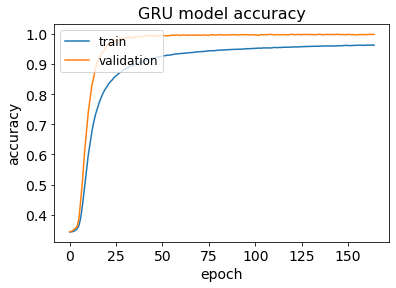

In [195]:
# summarize history for accuracy
plt.plot(gru_history['accuracy'])
plt.plot(gru_history['val_accuracy'])
plt.title('GRU model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

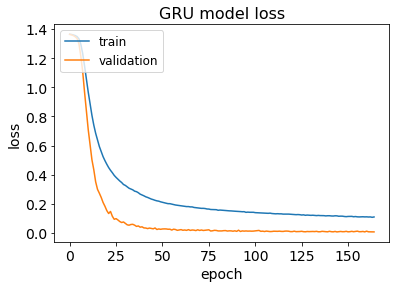

In [207]:
# summarize history for loss
plt.plot(gru_history['loss'])
plt.plot(gru_history['val_loss'])
plt.title('GRU model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

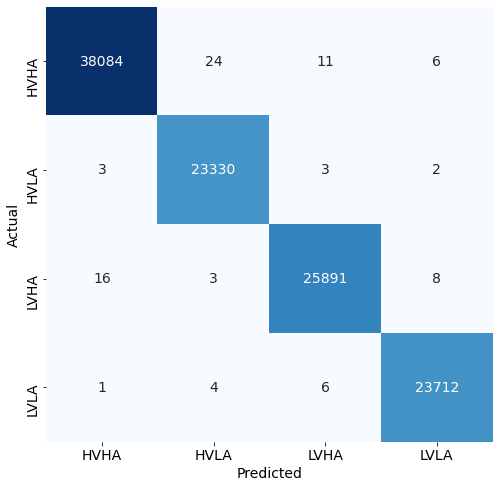

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38125
           1       1.00      1.00      1.00     23338
           2       1.00      1.00      1.00     25918
           3       1.00      1.00      1.00     23723

    accuracy                           1.00    111104
   macro avg       1.00      1.00      1.00    111104
weighted avg       1.00      1.00      1.00    111104



In [199]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = gru_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for GRU Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## LSTM Model

In [200]:
directory = 'C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.h5'
lstm_model = load_model(directory)
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 127, 128)          0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 127, 128)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 125, 128)          49280     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 62, 128)           0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 62, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 62, 256)         

In [201]:
lstm_history = np.load('C:\\.Farhad\\.Telkom\\Emotion Recognition\\Datasets\\DEAP\\all\\lstm_model.npy',allow_pickle='TRUE').item()
lstm_history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [202]:
print("Training Accuracy: ", np.max(lstm_history['accuracy']))
print("Training Loss: ", np.min(lstm_history['loss']))
print("Validation Accuracy: ", np.max(lstm_history['val_accuracy']))
print("Validation Loss: ", np.min(lstm_history['val_loss']))

Training Accuracy:  0.978035569190979
Training Loss:  0.06662584096193314
Validation Accuracy:  0.9999729990959167
Validation Loss:  0.0012957279104739428


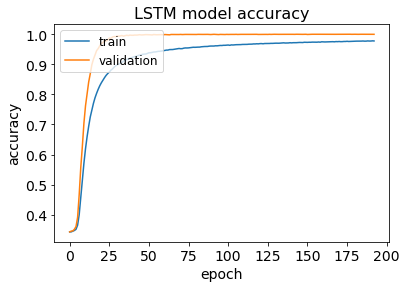

In [203]:
# summarize history for accuracy
plt.plot(lstm_history['accuracy'])
plt.plot(lstm_history['val_accuracy'])
plt.title('LSTM model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

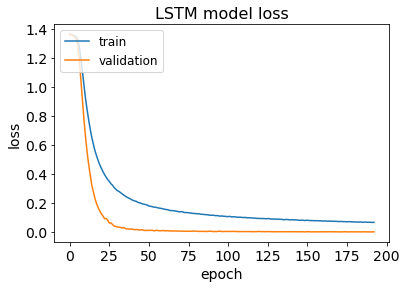

In [204]:
# summarize history for loss
plt.plot(lstm_history['loss'])
plt.plot(lstm_history['val_loss'])
plt.title('LSTM model loss', fontsize=16)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)
plt.show()

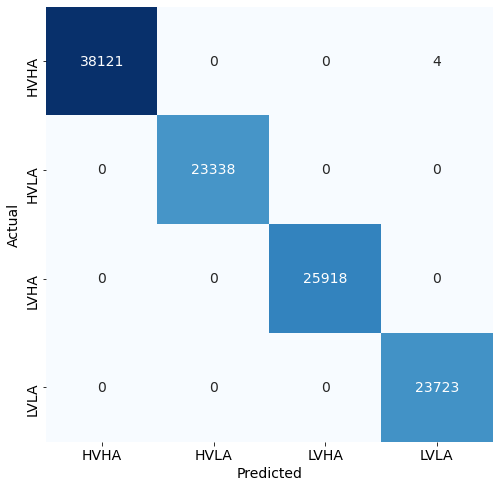

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38125
           1       1.00      1.00      1.00     23338
           2       1.00      1.00      1.00     25918
           3       1.00      1.00      1.00     23723

    accuracy                           1.00    111104
   macro avg       1.00      1.00      1.00    111104
weighted avg       1.00      1.00      1.00    111104



In [206]:
class_names = ['HVHA', 'HVLA', 'LVHA', 'LVLA']

y_pred = lstm_model.predict(x_test)

y_predict = []

for i in range(len(y_pred)):
    y_predict.append(np.argmax(y_pred[i]))

y_predict = np.array(y_predict)
yt_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(yt_test, y_predict)
clr = classification_report(yt_test, y_predict)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues', annot_kws={"size":14})
plt.xticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.yticks(np.arange(4) + 0.5, class_names, fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
# plt.title("Confusion Matrix for LSTM Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)